# Datasets

Датасет 1 - успеваемость студентов [ссылка](https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset)

В нем есть GPA и GradeClass, оба этих столбца это оценка, но GPA это вещественное значение, которое можно использовать для регрессии, а GradeClass можно использовать для классфикации.

Датасет 2 - спортзал [ссылка](https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset)

gym

В них нет пропусков данных.

In [1]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

import matplotlib.pyplot as plt

In [2]:
dataset1 = pd.read_csv("student_performance.csv")
dataset2 = pd.read_csv("gym_members.csv")

In [3]:
# Turn gender into int
dataset2['Gender'] = dataset2['Gender'].replace({'Female': '0', 'Male': '1'}).infer_objects(copy=False)

In [4]:
# One Hot Workout Type 
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)
dataset2 = encode_and_bind(dataset2, "Workout_Type")

In [5]:
# Classification dataset from dataset1
# Target is GradeClass
class_1 = dataset1.drop(columns=["Ethnicity", "StudentID", "GPA"])
X_class_1 = class_1.drop(["GradeClass"], axis=1)
y_class_1 = class_1["GradeClass"]

Xc1_train, Xc1_test, yc1_train, yc1_test = train_test_split(X_class_1, y_class_1, test_size=0.3)

In [6]:
# Classification dataset from dataset2
# Target is Gender
class_2 = dataset2.drop(columns=[])
X_class_2 = class_2.drop(["Gender"], axis=1)
y_class_2 = class_2["Gender"]

Xc2_train, Xc2_test, yc2_train, yc2_test = train_test_split(X_class_2, y_class_2, test_size=0.3)

In [7]:
# Regression dataset from dataset1
# Target is GPA (Grade Point Average)
regr_1 = dataset1.drop(columns=["Ethnicity", "StudentID", "GradeClass"])
X_regr_1 = regr_1.drop(["GPA"], axis=1)
y_regr_1 = regr_1["GPA"]

Xr1_train, Xr1_test, yr1_train, yr1_test = train_test_split(X_regr_1, y_regr_1, test_size=0.3)

In [34]:
# Regression dataset from dataset2
# Target is Calories_Burned
regr_2 = dataset2.drop(columns=[])
X_regr_2 = regr_2.drop(["Calories_Burned"], axis=1)
y_regr_2 = regr_2["Calories_Burned"]

Xr2_train, Xr2_test, yr2_train, yr2_test = train_test_split(X_regr_2, y_regr_2, test_size=0.3)

# Classification

## Dataset 1 (Student Performance)

### Decision Tree (Overfit)

In [8]:
# Decision tree (regression or classification) in sklearn is
# overfit by default and all its leaves are pure
dtc1_overfit = DecisionTreeClassifier()
dtc1_overfit.fit(Xc1_train, yc1_train);

In [9]:
print("Tree Accuracy", dtc1_overfit.score(Xc1_test, yc1_test))

Tree Accuracy 0.6044568245125348


### Decision Tree (Not Overfit)

In [10]:
dtc1 = DecisionTreeClassifier(
    min_samples_split=20,
    min_samples_leaf=7,
)
dtc1.fit(Xc1_train, yc1_train);

In [11]:
print("Tree Accuracy", dtc1.score(Xc1_test, yc1_test))

Tree Accuracy 0.6713091922005571


### Default Random Forest

```
n_estimators=100,
criterion='gini',
max_depth=None,
min_samples_split=2,
min_samples_leaf=1,
max_features='sqrt',
max_leaf_nodes=None,
```

In [12]:
rfc1_default = RandomForestClassifier()
rfc1_default.fit(Xc1_train, yc1_train);

In [13]:
print("Forest Accuracy", rfc1_default.score(Xc1_test, yc1_test))

Forest Accuracy 0.7047353760445683


In [14]:
rfc1_default_pred = rfc1_default.predict(Xc1_test)
print(classification_report(yc1_test, rfc1_default_pred))

              precision    recall  f1-score   support

         0.0       0.57      0.11      0.19        35
         1.0       0.53      0.53      0.53        76
         2.0       0.50      0.52      0.51       117
         3.0       0.53      0.49      0.51       131
         4.0       0.86      0.94      0.90       359

    accuracy                           0.70       718
   macro avg       0.60      0.52      0.53       718
weighted avg       0.69      0.70      0.69       718



In [38]:
# Importances should be labeled pandas series
def plot_mdi_importance(importance, title="Feature importances using MDI"):
    importance = importance.sort_values(ascending=False)
    fig, ax = plt.subplots()
    importance.plot.barh(ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Mean decrease in impurity")
    fig.tight_layout()

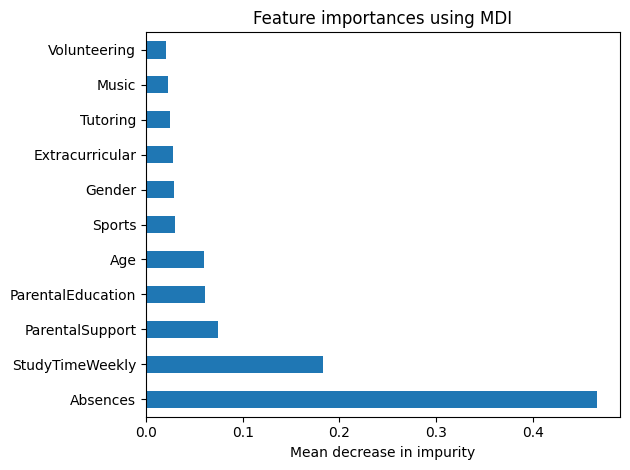

In [16]:
# Feature importance using mean decrease in impurity
rfc1_default_importances = pd.Series(rfc1_default.feature_importances_, index=Xc1_test.columns)
plot_mdi_importance(rfc1_default_importances)

### OOB Score Random Forest

In [17]:
# We have to enable out-of-bag score
# By default accuracy_score is used
rfc1_oob = RandomForestClassifier(
    oob_score=True,
)
rfc1_oob.fit(Xc1_train, yc1_train);

In [18]:
print("Forest OOB Score", rfc1_oob.oob_score_)

Forest OOB Score 0.7043010752688172


In [19]:
print("Forest Accuracy", rfc1_oob.score(Xc1_test, yc1_test))

Forest Accuracy 0.7019498607242339


In [20]:
rfc1_oob_pred = rfc1_oob.predict(Xc1_test)
print(classification_report(yc1_test, rfc1_oob_pred))

              precision    recall  f1-score   support

         0.0       0.62      0.14      0.23        35
         1.0       0.53      0.49      0.51        76
         2.0       0.50      0.55      0.52       117
         3.0       0.53      0.49      0.51       131
         4.0       0.85      0.93      0.89       359

    accuracy                           0.70       718
   macro avg       0.61      0.52      0.53       718
weighted avg       0.69      0.70      0.69       718



### Parameter tuning

In [21]:
def plot_score_features_subspace(feats, scores):
    fig, ax = plt.subplots()
    ax.plot(feats, scores)
    ax.set_xlabel("Features")
    ax.set_ylabel("Accuracy")
    fig.tight_layout()

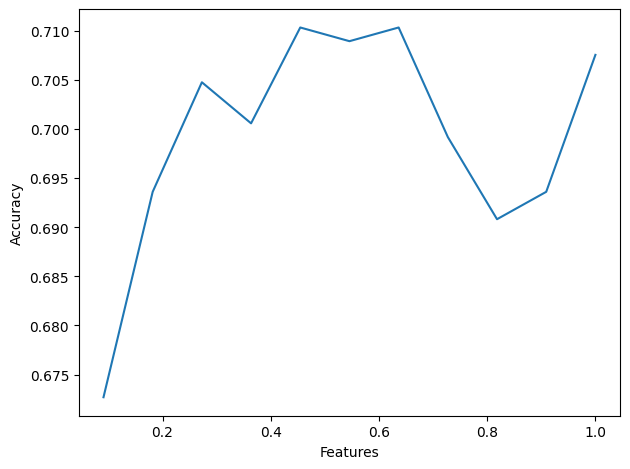

In [22]:
feats = []
scores = []
n = len(Xc1_train.columns)
for i in range(1, n+1):
    max_features = i/n
    rf = RandomForestClassifier(
        max_features=max_features,
    )
    rf.fit(Xc1_train, yc1_train)
    score = rf.score(Xc1_test, yc1_test)
    feats.append(max_features)
    scores.append(score)
plot_score_features_subspace(feats, scores)

## Dataset 2 (Gym Members)

### Default Random Forest

In [23]:
rfc2_default = RandomForestClassifier()
rfc2_default.fit(Xc2_train, yc2_train);

In [24]:
print("Forest Accuracy", rfc2_default.score(Xc2_test, yc2_test))

Forest Accuracy 0.976027397260274


In [25]:
rfc2_default_pred = rfc2_default.predict(Xc2_test)
print(classification_report(yc2_test, rfc2_default_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       145
           1       0.99      0.97      0.98       147

    accuracy                           0.98       292
   macro avg       0.98      0.98      0.98       292
weighted avg       0.98      0.98      0.98       292



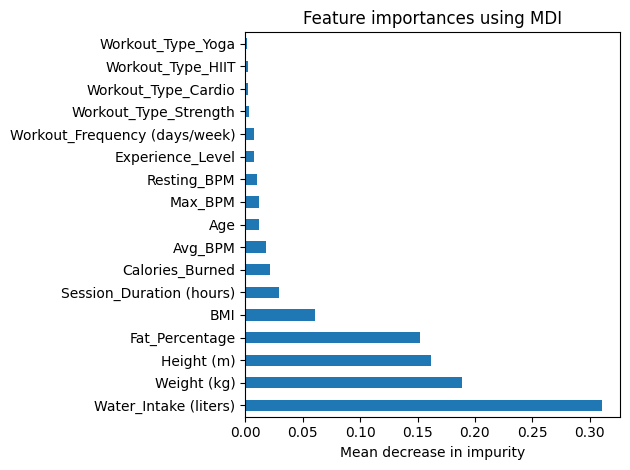

In [26]:
# Feature importance using mean decrease in impurity
rfc2_default_importances = pd.Series(rfc2_default.feature_importances_, index=Xc2_test.columns)
plot_mdi_importance(rfc2_default_importances)

### Parameter tuning

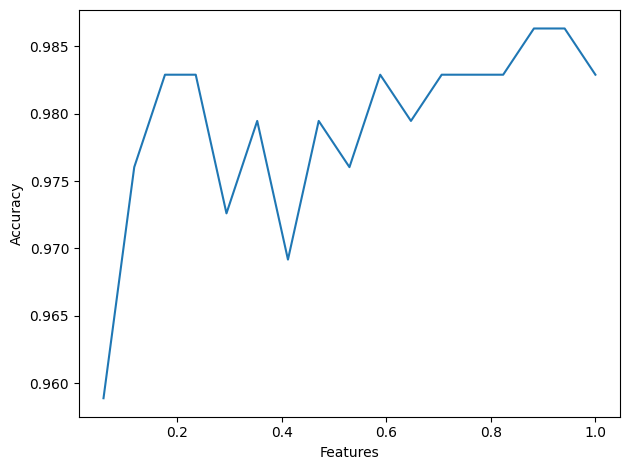

In [27]:
feats = []
scores = []
n = len(Xc2_train.columns)
for i in range(1, n+1):
    max_features = i/n
    rf = RandomForestClassifier(
        max_features=max_features,
    )
    rf.fit(Xc2_train, yc2_train)
    score = rf.score(Xc2_test, yc2_test)
    feats.append(max_features)
    scores.append(score)
plot_score_features_subspace(feats, scores)

# Regression

## Dataset 1 (Student Performance)

### Decision Tree (Overfit)

In [48]:
# Decision tree (regression or classification) in sklearn is
# overfit by default and all its leaves are pure
dtr1_overfit = DecisionTreeRegressor()
dtr1_overfit.fit(Xr1_train, yr1_train);

In [49]:
dtr1_overfit_pred = dtr1_overfit.predict(Xr1_test)
print("Tree Score (R2)", dtr1_overfit.score(Xr1_test, yr1_test))
print("Tree MAE", mean_absolute_error(yr1_test, dtr1_overfit_pred))
print("Tree MSE", mean_squared_error(yr1_test, dtr1_overfit_pred))

Tree Score (R2) 0.8604654083064522
Tree MAE 0.27319348337072075
Tree MSE 0.11586242098895773


### Decision Tree (Not Overfit)

In [46]:
dtr1= DecisionTreeRegressor(
    min_samples_split=20,
    min_samples_leaf=7,
)
dtr1.fit(Xr1_train, yr1_train);

In [47]:
dtr1_pred = dtr1.predict(Xr1_test)
print("Tree Score (R2)", dtr1.score(Xr1_test, yr1_test))
print("Tree MAE", mean_absolute_error(yr1_test, dtr1_pred))
print("Tree MSE", mean_squared_error(yr1_test, dtr1_pred))

Tree Score (R2) 0.895504194882668
Tree MAE 0.23969684818419243
Tree MSE 0.08676799650279302


### Default Random Forest

In [32]:
rfr1_default = RandomForestRegressor()
rfr1_default.fit(Xr1_train, yr1_train);

In [33]:
rfr1_default_pred = rfr1_default.predict(Xr1_test)
print("Forest Score (R2)", rfr1_default.score(Xr1_test, yr1_test))
print("Forest R2", r2_score(yr1_test, rfr1_default_pred))
print("Forest MAE", mean_absolute_error(yr1_test, rfr1_default_pred))
print("Forest MSE", mean_squared_error(yr1_test, rfr1_default_pred))

Forest Score (R2) 0.928449839399591
Forest R2 0.928449839399591
Forest MAE 0.19375176631044053
Forest MSE 0.059411610617093005


## Dataset 2 (Gym Members)

### Decision Tree (Not Overfit)

In [44]:
dtr2= DecisionTreeRegressor(
    min_samples_split=20,
    min_samples_leaf=7,
)
dtr2.fit(Xr2_train, yr2_train);

In [45]:
dtr2_pred = dtr2.predict(Xr2_test)
print("Tree Score (R2)", dtr2.score(Xr2_test, yr2_test))
print("Tree MAE", mean_absolute_error(yr2_test, dtr2_pred))
print("Tree MSE", mean_squared_error(yr2_test, dtr2_pred))

Tree Score (R2) 0.929545182017567
Tree MAE 56.28076621613574
Tree MSE 5346.857580454384


### Default Random Forest

In [35]:
rfr2_default = RandomForestRegressor()
rfr2_default.fit(Xr2_train, yr2_train);

In [36]:
rfr2_default_pred = rfr2_default.predict(Xr2_test)
print("Forest Score (R2)", rfr2_default.score(Xr2_test, yr2_test))
print("Forest R2", r2_score(yr2_test, rfr2_default_pred))
print("Forest MAE", mean_absolute_error(yr2_test, rfr2_default_pred))
print("Forest MSE", mean_squared_error(yr2_test, rfr2_default_pred))

Forest Score (R2) 0.9701316867145473
Forest R2 0.9701316867145473
Forest MAE 35.70928082191781
Forest MSE 2266.723864726027


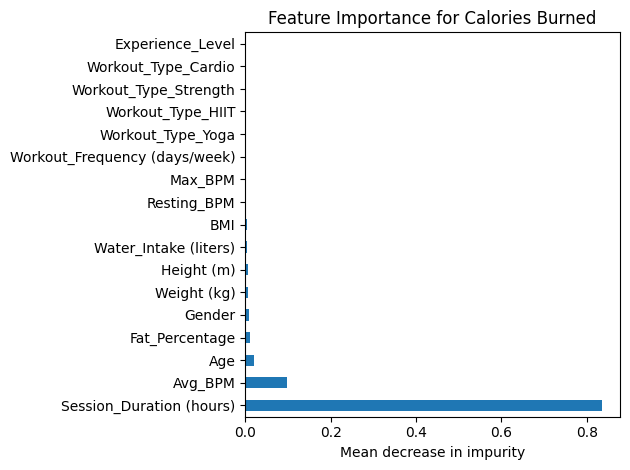

In [39]:
# Feature importance using mean decrease in impurity
rfr2_default_importances = pd.Series(rfr2_default.feature_importances_, index=Xr2_test.columns)
plot_mdi_importance(rfr2_default_importances, title="Feature Importance for Calories Burned")